Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 10, 'class_weight': None}
Optimized Random Forest Accuracy: 0.8226

Confusion Matrix:
[[3984  199]
 [ 747  403]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4183
           1       0.67      0.35      0.46      1150

    accuracy                           0.82      5333
   macro avg       0.76      0.65      0.68      5333
weighted avg       0.80      0.82      0.80      5333



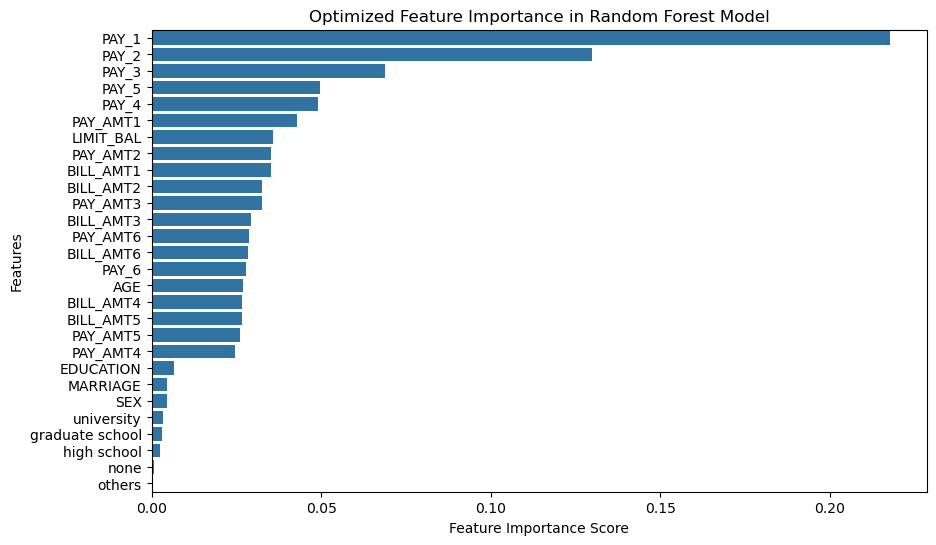

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load dataset
df = pd.read_csv('BestCard_data.csv')

# Define features and target
numerical_features = df.select_dtypes(include=['number']).columns.tolist()
target_variable = 'default payment next month'

if target_variable in numerical_features:
    numerical_features.remove(target_variable)

X = df[numerical_features]
y = df[target_variable]

# Train-test split (Single Call)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ✅ Convert to DataFrame to retain feature names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=numerical_features)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=numerical_features)

# Define parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 200, 300],  # Number of trees
    'max_depth': [10, 20, 30, None],  # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],  # Min samples required to split
    'min_samples_leaf': [1, 2, 4],  # Min samples per leaf
    'max_features': ['sqrt', 'log2', None],  # Number of features to consider at each split
    'class_weight': ['balanced', None]  # Handling class imbalance
}

# Initialize Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# ✅ Hyperparameter Tuning with RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=10,  # Number of different combinations to test
    cv=3,  # 3-fold cross-validation
    scoring='accuracy',
    verbose=1,
    n_jobs=-1,  # Use all processors
    random_state=42
)

# Fit RandomizedSearchCV on scaled data
random_search.fit(X_train_scaled_df, y_train)

# Get the best parameters
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# ✅ Retrain Optimized Model with Best Parameters
optimized_rf = RandomForestClassifier(**best_params, random_state=42)
optimized_rf.fit(X_train_scaled_df, y_train)  # ✅ Retraining with optimized parameters

# Make predictions with the optimized model
y_pred_optimized = optimized_rf.predict(X_test_scaled_df)

# Evaluate the optimized model
accuracy_optimized_rf = accuracy_score(y_test, y_pred_optimized)
conf_matrix_optimized_rf = confusion_matrix(y_test, y_pred_optimized)
report_optimized_rf = classification_report(y_test, y_pred_optimized)

# Print evaluation results
print(f"Optimized Random Forest Accuracy: {accuracy_optimized_rf:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix_optimized_rf)
print("\nClassification Report:")
print(report_optimized_rf)

# ✅ Get Feature Importance from the Final Model
rf_importance_optimized = pd.DataFrame({
    'Feature': X_train_scaled_df.columns,
    'Importance': optimized_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=rf_importance_optimized)
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Optimized Feature Importance in Random Forest Model")
plt.show()

# ✅ Save the Final Model and Scaler for Streamlit
pickle.dump(optimized_rf, open("optimized_rf.pkl", "wb"))
pickle.dump(scaler, open("scaler.pkl", "wb"))
pickle.dump(numerical_features, open("features.pkl", "wb"))


In [15]:
df['PAY_TO_BILL_RATIO'] = df['PAY_AMT1'] / (df['BILL_AMT1'] + 1e-6)
df['CREDIT_UTILIZATION_RATIO'] = df['BILL_AMT1'] / (df['LIMIT_BAL'] + 1e-6)

df['TOTAL_BILLS'] = df[[f'BILL_AMT{i}' for i in range(1, 7)]].sum(axis=1)
df['TOTAL_PAYMENTS'] = df[[f'PAY_AMT{i}' for i in range(1, 7)]].sum(axis=1)

df['PAY_TREND'] = df[[f'PAY_{i}' for i in range(1, 7)]].mean(axis=1)

important_features = optimized_rf.feature_importances_ > 0.01  # Select top features
X = X.loc[:, important_features]

scoring = 'roc_auc'  # Replace with desired metric

In [17]:
# Save the model and feature list
import pickle
pickle.dump(optimized_rf, open("optimized_rf.pkl", "wb"))
pickle.dump(numerical_features, open("features.pkl", "wb"))
pickle.dump(df, open("df.pkl", "wb"))

In [19]:
from sklearn.preprocessing import StandardScaler
import pickle

# Initialize and fit the scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the scaler for later use in Streamlit
pickle.dump(scaler, open("scaler.pkl", "wb"))

# Train RandomForestClassifier on scaled data
optimized_rf.fit(X_train_scaled, y_train)

# Save the trained model
pickle.dump(optimized_rf, open("optimized_rf.pkl", "wb"))

In [21]:
%%writefile untitled15_1.py

import streamlit as st
import numpy as np
import pandas as pd
import pickle

# Load saved objects
optimized_rf = pickle.load(open("optimized_rf.pkl", "rb"))
scaler = pickle.load(open("scaler.pkl", "rb"))
numerical_features = pickle.load(open("features.pkl", "rb"))  # Load original feature names

# Ensure user inputs match model features
st.title("Credit Default Prediction App")
st.write("This app predicts if a customer will default next month based on financial data.")

# Collect user inputs
credit_limit = st.number_input("Credit Limit", min_value=0, value=50000)
age = st.number_input("Age", min_value=18, max_value=100, value=30)
bill_amt = st.number_input("Last Month's Bill Amount", min_value=0, value=10000)
pay_amt = st.number_input("Last Month's Payment Amount", min_value=0, value=5000)
pay_status = st.selectbox("Repayment Status Last Month", ["No Delay", "Delayed by 1 Month", "Delayed by 2 Months"])

# Convert categorical value PAY_1 before inserting into DataFrame
pay_status_mapping = {
    "No Delay": 0,
    "Delayed by 1 Month": 1,
    "Delayed by 2 Months": 2
}
pay_status_encoded = pay_status_mapping[pay_status]  # Convert to integer

# Calculate ratios (Only if these were used in training)
pay_to_bill_ratio = pay_amt / (bill_amt + 1e-6)
credit_utilization_ratio = bill_amt / (credit_limit + 1e-6)

# **Ensure correct feature order and match training data**
input_data = pd.DataFrame(columns=numerical_features)  # Match feature order

# Assign user inputs to the correct columns
input_data.loc[0] = [0] * len(numerical_features)  # Initialize all features with zero
if 'LIMIT_BAL' in numerical_features:
    input_data['LIMIT_BAL'] = credit_limit
if 'AGE' in numerical_features:
    input_data['AGE'] = age
if 'BILL_AMT1' in numerical_features:
    input_data['BILL_AMT1'] = bill_amt  # Ensure the correct column name
if 'PAY_AMT1' in numerical_features:
    input_data['PAY_AMT1'] = pay_amt
if 'PAY_TO_BILL_RATIO' in numerical_features:
    input_data['PAY_TO_BILL_RATIO'] = pay_to_bill_ratio
if 'CREDIT_UTILIZATION_RATIO' in numerical_features:
    input_data['CREDIT_UTILIZATION_RATIO'] = credit_utilization_ratio
if 'PAY_1' in numerical_features:
    input_data['PAY_1'] = pay_status_encoded  # ✅ Fixed mapping issue

# Ensure all columns are numeric
input_data = input_data.astype(float)

# Apply feature scaling
input_data_scaled = scaler.transform(input_data)

# Make prediction
if st.button("Predict Default Risk"):
    probability = optimized_rf.predict_proba(input_data_scaled)[0][1]
    
    # Set a decision threshold (default is 0.5, adjust if necessary)
    threshold = 0.5
    prediction = 1 if probability >= threshold else 0

    if prediction == 1:
        st.error(f"⚠ High Risk of Default! Probability: {probability:.2f}")
    else:
        st.success(f"✅ Low Risk of Default. Probability: {probability:.2f}")


Overwriting untitled15_1.py


In [ ]:
!streamlit run untitled15_1.py